In [1]:
!pip install ultralytics "numpy==1.26.4" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curre

In [2]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
import cv2
from ultralytics import YOLO
from tqdm import tqdm
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
INPUT_DIR = '/kaggle/input/kitti-dataset' 

# Original dataset paths
IMG_DIR = os.path.join(INPUT_DIR, 'data_object_image_2/training/image_2')
LABEL_DIR = os.path.join(INPUT_DIR, 'data_object_label_2/training/label_2')

# New working directory for organized dataset
WORKING_DIR = '/kaggle/working/kitti_dataset'

# Create the directories for our YOLO-formatted dataset
os.makedirs(os.path.join(WORKING_DIR, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, 'labels/val'), exist_ok=True)

# Define the classes we want to detect
# map KITTI classes to new integer IDs
# merging 'Van' and 'Truck' into 'Car'
# 'Person_sitting' into 'Pedestrian'
KITTI_CLASSES = {
    'Car': 0,
    'Van': 0,  # Map Van to Car
    'Truck': 0, # Map Truck to Car
    'Pedestrian': 1,
    'Person_sitting': 1, # Map Person_sitting to Pedestrian
    'Cyclist': 2
    # ignore 'Tram', 'Misc', 'DontCare'
}

# the final list for YAML file
YOLO_CLASSES = ['Car', 'Pedestrian', 'Cyclist']

print(f"Input image directory: {IMG_DIR}")
print(f"Input label directory: {LABEL_DIR}")
print(f"Working directory: {WORKING_DIR}")

Input image directory: /kaggle/input/kitti-dataset/data_object_image_2/training/image_2
Input label directory: /kaggle/input/kitti-dataset/data_object_label_2/training/label_2
Working directory: /kaggle/working/kitti_dataset


In [4]:
def convert_kitti_to_yolo(kitti_label_path, yolo_label_path, img_width, img_height):
    """
    Converts a single KITTI label file to YOLO format.
    """
    try:
        with open(kitti_label_path, 'r') as f_in, open(yolo_label_path, 'w') as f_out:
            for line in f_in.readlines():
                parts = line.strip().split()
                class_name = parts[0]
                
                # Skip classes we don't care about
                if class_name not in KITTI_CLASSES:
                    continue
                
                class_id = KITTI_CLASSES[class_name]
                
                # Get bounding box coordinates
                x1 = float(parts[4])
                y1 = float(parts[5])
                x2 = float(parts[6])
                y2 = float(parts[7])
                
                # Convert to YOLO format (normalized x_center, y_center, width, height)
                box_width = (x2 - x1) / img_width
                box_height = (y2 - y1) / img_height
                x_center = (x1 + x2) / 2.0 / img_width
                y_center = (y1 + y2) / 2.0 / img_height
                
                # Write to new label file
                f_out.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")
    except Exception as e:
        print(f"Error processing {kitti_label_path}: {e}")

# Get all image file paths
all_img_paths = sorted(glob.glob(os.path.join(IMG_DIR, '*.png')))

# Split into training and validation sets
train_paths, val_paths = train_test_split(all_img_paths, test_size=0.2, random_state=42)

print(f"Total images: {len(all_img_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

# Process training files
print("Processing training files...")
for img_path in tqdm(train_paths):
    # Get image dimensions
    try:
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape
    except Exception as e:
        print(f"Skipping broken image: {img_path}, Error: {e}")
        continue
    
    # Define file names and paths
    file_name = os.path.basename(img_path)
    label_name = file_name.replace('.png', '.txt')
    
    kitti_label_path = os.path.join(LABEL_DIR, label_name)
    yolo_label_path = os.path.join(WORKING_DIR, 'labels/train', label_name)
    yolo_img_path = os.path.join(WORKING_DIR, 'images/train', file_name)
    
    # Convert label
    convert_kitti_to_yolo(kitti_label_path, yolo_label_path, img_width, img_height)
    
    # Copy image
    shutil.copy(img_path, yolo_img_path)

# Process validation files
print("Processing validation files...")
for img_path in tqdm(val_paths):
    # Get image dimensions
    try:
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape
    except Exception as e:
        print(f"Skipping broken image: {img_path}, Error: {e}")
        continue
        
    # Define file names and paths
    file_name = os.path.basename(img_path)
    label_name = file_name.replace('.png', '.txt')
    
    kitti_label_path = os.path.join(LABEL_DIR, label_name)
    yolo_label_path = os.path.join(WORKING_DIR, 'labels/val', label_name)
    yolo_img_path = os.path.join(WORKING_DIR, 'images/val', file_name)
    
    # Convert label
    convert_kitti_to_yolo(kitti_label_path, yolo_label_path, img_width, img_height)
    
    # Copy image
    shutil.copy(img_path, yolo_img_path)

print("Dataset processing complete.")

Total images: 7481
Training images: 5984
Validation images: 1497
Processing training files...


100%|██████████| 5984/5984 [03:08<00:00, 31.73it/s]


Processing validation files...


100%|██████████| 1497/1497 [00:48<00:00, 30.85it/s]

Dataset processing complete.


In [5]:
print("--- First 5 training images: ---")
!ls /kaggle/working/kitti_dataset/images/train | head -n 5

print("\n--- First 5 training labels: ---")
!ls /kaggle/working/kitti_dataset/labels/train | head -n 5

--- First 5 training images: ---
000001.png
000002.png
000003.png
000004.png
000005.png
ls: write error: Broken pipe

--- First 5 training labels: ---
000001.txt
000002.txt
000003.txt
000004.txt
000005.txt
ls: write error: Broken pipe


In [6]:
# Create the dataset.yaml file content
data_yaml = {
    'path': WORKING_DIR,  # Root directory of our dataset
    'train': 'images/train',  # Path to training images (relative to 'path')
    'val': 'images/val',      # Path to validation images (relative to 'path')
    'names': {i: name for i, name in enumerate(YOLO_CLASSES)} # Class names
}

# Write the yaml file
yaml_path = os.path.join(WORKING_DIR, 'kitti.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"Created {yaml_path}")
print("--- YAML Content ---")
with open(yaml_path, 'r') as f:
    print(f.read())

Created /kaggle/working/kitti_dataset/kitti.yaml
--- YAML Content ---
names:
  0: Car
  1: Pedestrian
  2: Cyclist
path: /kaggle/working/kitti_dataset
train: images/train
val: images/val



In [7]:
# Load a pre-trained YOLOv8 'nano' model
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(
    data=yaml_path,       # Path to our kitti.yaml file
    epochs=25,            # Number of epochs to train
    imgsz=640,            # Image size (640x640)
    batch=16,             # Batch size
    name='yolov8n_kitti'  # Name for the results folder
)

Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/kitti_dataset/kitti.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_kitti, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1497       7949      0.881      0.733      0.833      0.548
                   Car       1356       6686       0.91      0.882      0.946      0.738
            Pedestrian        364        955      0.845      0.606      0.741      0.409
               Cyclist        222        308      0.887      0.712      0.811      0.498
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/yolov8n_kitti


In [8]:
# The model variable is automatically updated to the best checkpoint
# You can also load the best checkpoint manually:
# model = YOLO('/kaggle/working/runs/detect/yolov8n_kitti/weights/best.pt')

print("Validating model on the validation set...")
metrics = model.val()

print("\n--- Validation Metrics ---")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"mAP75: {metrics.box.map75}")

Validating model on the validation set...
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5421.8±853.5 MB/s, size: 787.5 KB)
val: Scanning /kaggle/working/kitti_dataset/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1497/1497 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 8.1it/s 11.6s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1497       7949      0.879      0.735      0.833       0.55
                   Car       1356       6686      0.908      0.882      0.946      0.739
            Pedestrian        364        955      0.845      0.607      0.742       0.41
               Cyclist        222        308      0.885      0.714      0.811        0.5
Speed: 0.4ms preprocess, 1.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

--- Validation Metrics ---
mAP50-95: 0.5496678921103904
mAP50: 0.8330789709905897
mAP75: 0.6078591436883538


Running prediction on 3 random test images...

0: 224x640 2 Cars, 11.6ms
1: 224x640 11 Cars, 11.6ms
2: 224x640 4 Cars, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Results saved to /kaggle/working/runs/detect/kitti_test_predictions

--- Prediction Results ---


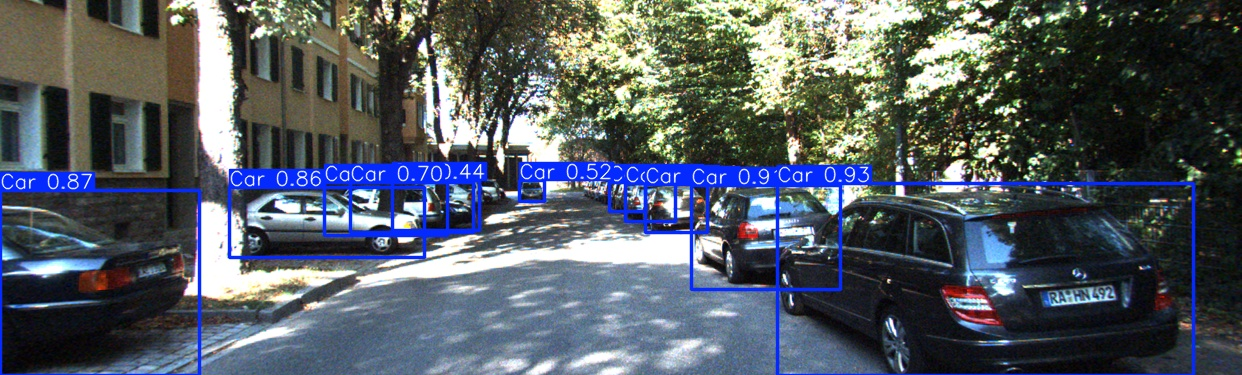

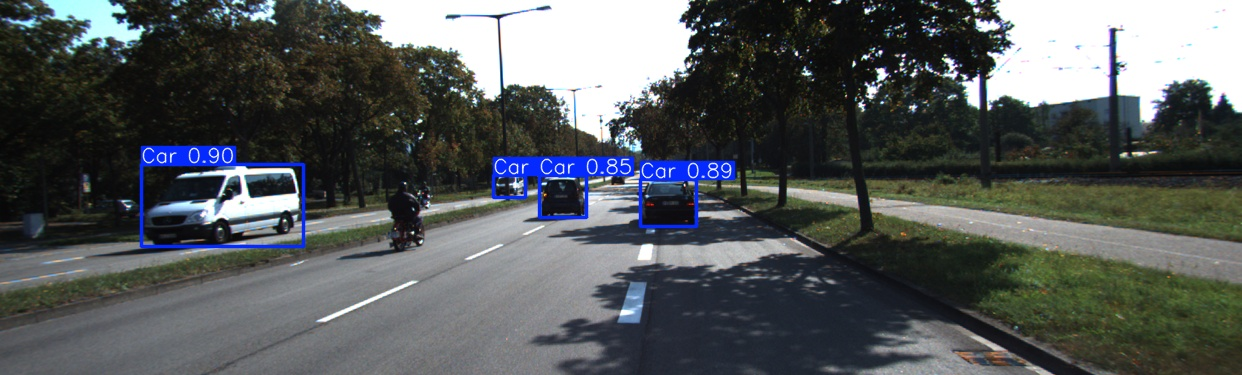

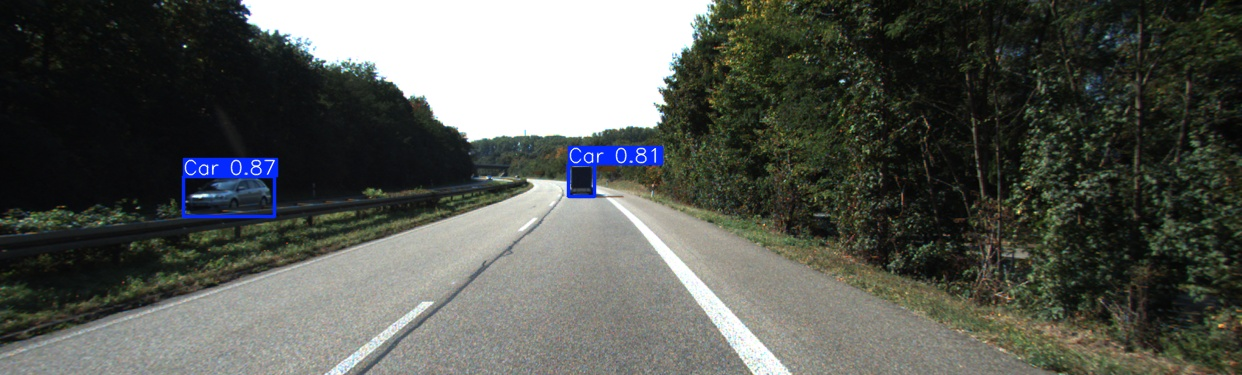

In [9]:
import random
from IPython.display import Image, display

# Path to the original KITTI test images (which have no labels)
TEST_IMG_DIR = os.path.join(INPUT_DIR, 'data_object_image_2/testing/image_2')
test_image_paths = glob.glob(os.path.join(TEST_IMG_DIR, '*.png'))

# Pick 3 random test images
random_samples = random.sample(test_image_paths, 3)

print(f"Running prediction on {len(random_samples)} random test images...")

# Run prediction
# We save the results to a new directory and don't display them yet
results = model.predict(
    random_samples, 
    save=True,  # Save the annotated images
    project='/kaggle/working/runs/detect', 
    name='kitti_test_predictions'
)

# Display the saved images with bounding boxes
print("\n--- Prediction Results ---")
prediction_dir = results[0].save_dir
for img_file in os.listdir(prediction_dir):
    if img_file.endswith('.jpg'):
        display(Image(filename=os.path.join(prediction_dir, img_file)))

In [10]:
# Install the OpenCV contrib package for stereo vision functions
!pip install --upgrade pip -q
!pip install opencv-contrib-python -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
on

In [11]:
!pip install "numpy==1.26.4" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Define new paths for depth estimation ---

# Path to the right camera images
RIGHT_IMG_DIR = os.path.join(INPUT_DIR, 'data_object_image_3/training/image_3')

# Path to the calibration files
CALIB_DIR = os.path.join(INPUT_DIR, 'data_object_calib/training/calib')

print(f"Right image directory: {RIGHT_IMG_DIR}")
print(f"Calibration directory: {CALIB_DIR}")

Right image directory: /kaggle/input/kitti-dataset/data_object_image_3/training/image_3
Calibration directory: /kaggle/input/kitti-dataset/data_object_calib/training/calib


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import Image, display

def parse_calib_file(calib_path):
    """
    Reads a KITTI calibration file and returns the focal length (f) 
    and baseline (B) for the stereo cameras.
    """
    f = None
    tx = None
    
    with open(calib_path, 'r') as f_in:
        for line in f_in.readlines():
            
            # 1. Strip whitespace from the beginning/end of the line
            clean_line = line.strip()
            
            # 2. Check the *stripped* line
            if clean_line.startswith('P2:'):
                # 3. Split by *any* whitespace (more robust)
                parts = clean_line.split()
                f = float(parts[1]) # f_x (focal length)
            
            elif clean_line.startswith('P3:'):
                # 3. Split by *any* whitespace
                parts = clean_line.split()
                # The f_x in P3 is the same, but P3 has the tx offset
                tx = float(parts[4]) # tx
    
    if f is None or tx is None:
        raise ValueError(f"Could not parse f or tx from {calib_path}")

    # B = -tx / f_x
    B = -tx / f
    return f, B

# --- GPU-ACCELERATED FUNCTION ---

def create_gpu_stereo_matcher():
    """
    Creates a high-speed CUDA-enabled StereoSGBM object.
    """
    # Robust check for CUDA-enabled OpenCV
    # Check if the 'cuda' attribute exists AND if the 'createStereoSGBM' method exists
    if hasattr(cv2, 'cuda') and hasattr(cv2.cuda, 'createStereoSGBM'):
        print("CUDA detected. Creating fast GPU Stereo Matcher.")
        return cv2.cuda.createStereoSGBM(
            minDisparity=0,
            numDisparities=128,
            blockSize=11
        )
    
    print("CUDA not available. Falling back to slow CPU version.")
    return cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=128,
        blockSize=11
    )

def calculate_gpu_disparity_map(stereo_matcher, imgL_path, imgR_path):
    """
    Computes the disparity map from a left/right image pair using the GPU.
    """
    imgL = cv2.imread(imgL_path, 0)
    imgR = cv2.imread(imgR_path, 0)
    
    # --- THIS IS THE FIX ---
    # The creator function *only* returns a GPU object if it can.
    # We can check the type by its name as a string, which is safe.
    matcher_type_name = type(stereo_matcher).__name__

    if matcher_type_name == 'cuda_StereoSGBM':
        # --- Upload images to GPU memory ---
        gpu_imgL = cv2.cuda_GpuMat()
        gpu_imgR = cv2.cuda_GpuMat()
        gpu_imgL.upload(imgL)
        gpu_imgR.upload(imgR)

        # --- Compute disparity on the GPU ---
        gpu_disparity = stereo_matcher.compute(gpu_imgL, gpu_imgR)
        
        # --- Download the result from GPU memory ---
        disparity = gpu_disparity.download()
    else:
        # --- Compute disparity on the CPU ---
        # This will now be called correctly
        disparity = stereo_matcher.compute(imgL, imgR)
    
    # Convert from 16-bit fixed-point to float
    disparity = disparity.astype(np.float32) / 16.0
    return disparity

In [14]:
print("Filtering validation files for valid calibration data...")

good_val_paths = []
bad_file_count = 0

for img_path in tqdm(val_paths):
    file_name = os.path.basename(img_path)
    calib_path = os.path.join(CALIB_DIR, file_name.replace('.png', '.txt'))

    if not os.path.exists(calib_path):
        bad_file_count += 1
        continue
    
    try:
        # Try to parse the file
        f, B = parse_calib_file(calib_path)
        # If it works, add the image path to our good list
        good_val_paths.append(img_path)
    except ValueError:
        # If it fails, it's a malformed file
        bad_file_count += 1

print(f"Filtering complete.")
print(f"Found {len(good_val_paths)} valid files.")
print(f"Ignored {bad_file_count} files with missing/bad calibration.")

Filtering validation files for valid calibration data...


100%|██████████| 1497/1497 [00:12<00:00, 122.53it/s]

Filtering complete.
Found 1497 valid files.
Ignored 0 files with missing/bad calibration.


In [15]:
print("--- DEBUG: Displaying contents of a sample calibration file ---")

# Let's use one of the files that failed before
debug_calib_path = '/kaggle/input/kitti-dataset/data_object_calib/training/calib/003872.txt'

try:
    with open(debug_calib_path, 'r') as f:
        print(f.read())
except Exception as e:
    print(f"Error reading file: {e}")

--- DEBUG: Displaying contents of a sample calibration file ---
P0: 7.188560000000e+02 0.000000000000e+00 6.071928000000e+02 0.000000000000e+00 0.000000000000e+00 7.188560000000e+02 1.852157000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.188560000000e+02 0.000000000000e+00 6.071928000000e+02 -3.861448000000e+02 0.000000000000e+00 7.188560000000e+02 1.852157000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.188560000000e+02 0.000000000000e+00 6.071928000000e+02 4.538225000000e+01 0.000000000000e+00 7.188560000000e+02 1.852157000000e+02 -1.130887000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 3.779761000000e-03
P3: 7.188560000000e+02 0.000000000000e+00 6.071928000000e+02 -3.372877000000e+02 0.000000000000e+00 7.188560000000e+02 1.852157000000e+02 2.369057000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 4.915215000000e-03
R0_re

CUDA not available. Falling back to slow CPU version.
Attempting to process: 007475.png
Successfully processed: 007475.png

Saved final result to /kaggle/working/depth_007475.png


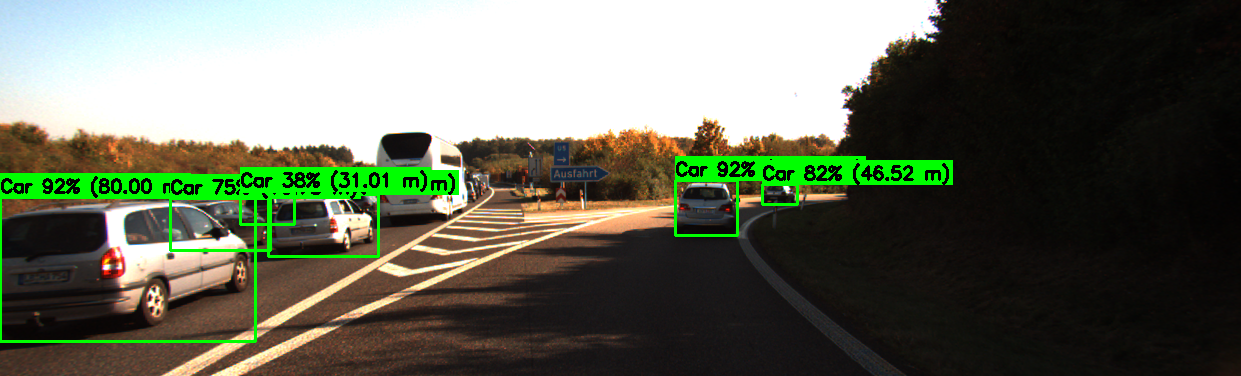

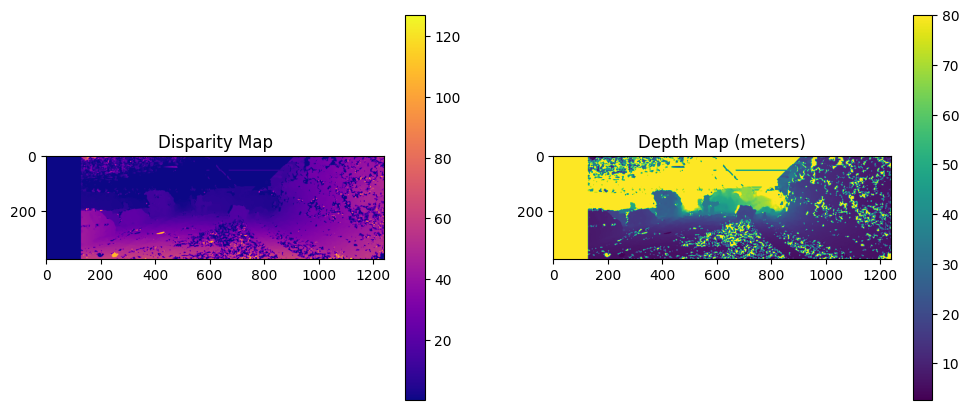

In [16]:
# 1. --- Create the Stereo Matcher (once) ---
# This will be either a fast GPU or slow CPU version.
stereo = create_gpu_stereo_matcher()

# 2. --- Loop until we find a valid image and calibration file ---
while True:
    try:
        if 'val_paths' not in globals() or len(val_paths) == 0:
            print("Error: 'val_paths' not found. Please re-run Cell 4.")
            break

        # 3. --- Pick a random validation image to test on ---
        sample_img_path = random.choice(val_paths)
        file_name = os.path.basename(sample_img_path)

        # 4. --- Define all necessary paths ---
        left_img_path = sample_img_path
        right_img_path = os.path.join(RIGHT_IMG_DIR, file_name)
        calib_path = os.path.join(CALIB_DIR, file_name.replace('.png', '.txt'))

        # Check if all files exist
        if not all(os.path.exists(p) for p in [left_img_path, right_img_path, calib_path]):
            print(f"Skipping {file_name}: Missing corresponding image or calib file.")
            continue # Try a new random file

        print(f"Attempting to process: {file_name}")

        # 5. --- Get Calibration Data (This is where the error can happen) ---
        f, B = parse_calib_file(calib_path)
        
        # --- If we get here, the file is valid! ---
        print(f"Successfully processed: {file_name}")
        
        # 6. --- Run Object Detection (Fast) ---
        results = model.predict(left_img_path, verbose=False)

        # 7. --- Get Disparity Map (CPU or GPU) ---
        disparity_map = calculate_gpu_disparity_map(stereo, left_img_path, right_img_path)

        # 8. --- Calculate Depth Map ---
        disparity_map[disparity_map <= 0] = 0.1
        depth_map = (f * B) / disparity_map
        depth_map[depth_map > 80] = 80 # Clamp depth

        # 9. --- Load image for drawing ---
        img_with_boxes = cv2.imread(left_img_path)

        # 10. --- Combine Detection and Depth ---
        for box in results[0].boxes:
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = xyxy
            class_id = int(box.cls[0])
            class_name = model.names[class_id]
            conf = float(box.conf[0])

            depth_roi = depth_map[y1:y2, x1:x2]
            valid_depths = depth_roi[depth_roi > 0.1]

            if valid_depths.size > 0:
                obj_depth_m = np.median(valid_depths)
                depth_text = f"{obj_depth_m:.2f} m"
            else:
                depth_text = "N/A"

            # 11. --- Draw Bounding Box and Text ---
            label = f"{class_name} {conf*100:.0f}% ({depth_text})"
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(img_with_boxes, (x1, y1 - h - 10), (x1 + w, y1), (0, 255, 0), -1)
            cv2.putText(img_with_boxes, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

        # 12. --- Save and Display Results ---
        output_path = f"/kaggle/working/depth_{file_name}"
        cv2.imwrite(output_path, img_with_boxes)

        print(f"\nSaved final result to {output_path}")
        display(Image(filename=output_path))

        # Optional: Display the disparity and depth maps
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Disparity Map")
        plt.imshow(disparity_map, cmap='plasma')
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.title("Depth Map (meters)")
        plt.imshow(depth_map, cmap='viridis')
        plt.colorbar()
        plt.savefig('/kaggle/working/depth_map.png')
        plt.show()
        
        # --- Exit the loop ---
        break

    except ValueError as e:
        # This catches the "Could not parse" error from parse_calib_file
        print(f"Bad calibration file: {e}. Trying another file...")
    except Exception as e:
        # Catch any other unexpected errors
        print(f"An unexpected error occurred: {e}. Trying another file...")